# Install GEM package and its dependences
The currect version of GEM is designed to demonstrate proof of concept and was built on what is now an old version of tensorflow.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/jewellcp/tmp/gem


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from matplotlib import rcParams

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Example 1: SIR

## Define SIR model
The `MyEpidemic()` model defines both the states (`S`, `I` and `R`) along with their initial values and also the form of the transition rates between the states (`S->I` and `I->R`).  The final line instantiates the epidemic model defined in `prog`.

In [4]:
from gem import GEM
#from gem.plotting import plot_timeseries, traceplot

prog = """
prior_parms = Vector()
beta ~ Gamma(prior_parms[0], prior_parms[1])
gamma ~ Gamma(1.0, 10.0)

Epidemic MyEpidemic() {

    S = State(init=990)
    I = State(init=10)
    R = State(init=0)
    
    [S -> I] = beta * I / 1000.0
    [I -> R] = [gamma]  # Make gamma broadcast as a vector
}
epi ~ MyEpidemic()
"""

model = GEM(prog, const_data={'prior_parms': [0.2, 10.0]})

Subscript list: [Integer 0]
Expression: IdRef(prior_parms)[IndexList]
Subscript list: [Integer 1]
Expression: IdRef(prior_parms)[IndexList]


In [5]:
from gem.gemlang import ast2dot
graph = ast2dot(model.ast)
graph.view()

'AST.gv.pdf'

In [12]:
print(model.pyprog)

### Start of GEM-generated code ###
import tensorflow as tf
import tensorflow_probability as tfp
from gemlib import distributions as gld
tfd = tfp.distributions
Root = tfd.JointDistributionCoroutine.Root
def model_impl_fn():
    prior_parms = gem_external['prior_parms']
    beta = yield Root(tfd.Gamma(concentration=prior_parms[0], rate=prior_parms[1], name='beta'))
    gamma = yield Root(tfd.Gamma(concentration=1.0, rate=10.0, name='gamma'))
            
    def MyEpidemic( name=None):
        stoichiometry_ = tf.constant([[-1, 1, 0,],[ 0,-1, 1,],], dtype=tf.float32)
        initial_state_ = tf.stack([tf.cast([990], tf.float32),tf.cast([10], tf.float32),tf.cast([0], tf.float32),], axis=-1)
        
        def h(t, state):
            with tf.name_scope('MyEpidemic_h') as scope:
                state = tf.cast(state, tf.float32)
                state = tf.unstack(state, axis=-1)
                state_shape = state[0].shape
                S,I,R = state
                return [
        

## Display DAG
A DAG of stochastic nodes in `model` is generated in the following.

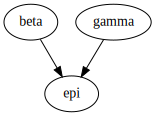

In [7]:
from gem.gemlang.dag import DAG
dag = DAG(model.ast)
dag.dot()

## Simulation
The instantiated `model` can be used for the forward simulation of an epidemic.  In this instance the transition coeffients for `beta` and `gamma` are defined as constants e.g.`beta` is set to `0.8`.

In [13]:
import tensorflow as tf
sim = tf.function(lambda: model.sample(1, condition_vars={'beta': 0.3, 'gamma': 0.1}))()  # Will require shape/type checking here. 

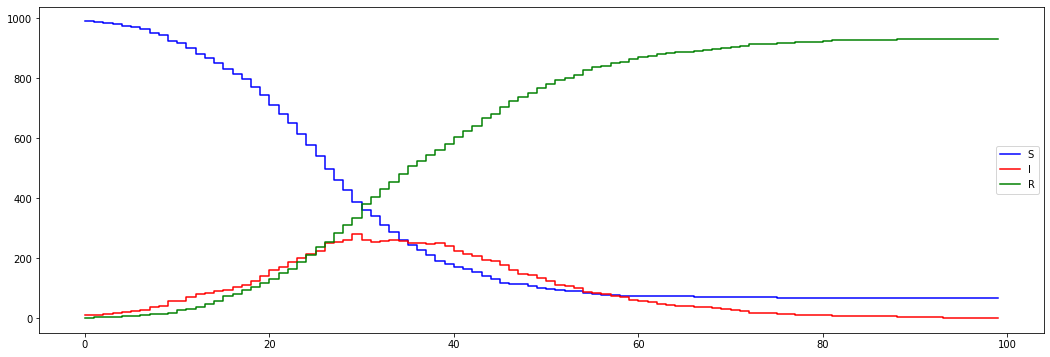

In [14]:
from gem.plotting import plot_state_timeseries
plot_state_timeseries(model['epi'], sim.epi, state_labels=("S", "I", "R"))

## Inference
Alternatively the instantiated `model` can be used for inference in which case the transition coeffients are estimated using their respective proiors. In this example the prior on `beta` is `Gamma(1,10)` as defined above in `prog`.

In [10]:
posterior, accept = model.fit(observed={'epi': sim.epi}, n_samples=5000, num_burnin_steps=500, init={'beta': 0.8, 'gamma': 0.1})

Sampling...


/home/jewellcp/.cache/pypoetry/virtualenvs/gem-kG1TN-IU-py3.7/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
2021-11-04 13:00:06.802347: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x55ace6d9c2f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-04 13:00:06.802398: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2021-11-04 13:00:06.885917: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2021-11-04 13:00:06.931793: W tensorflow/compiler/tf2xla/kernels/random_ops.cc

Done in 5.47715401700043 seconds


## Plot samples
The top row of plots relates to the `beta` estimates while the bottom row relates to `gamma`.


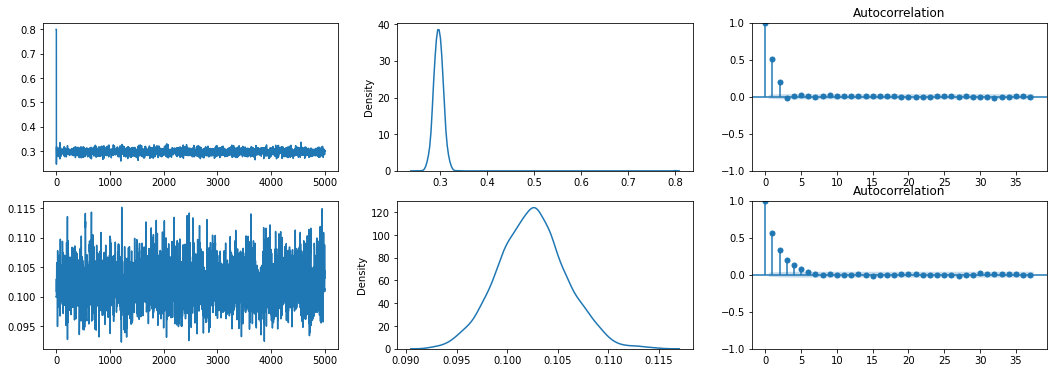

In [11]:
from gem.plotting import traceplot

rcParams['figure.figsize'] = (18, 6)

_ = traceplot(posterior)